https://www.tensorflow.org/responsible_ai/privacy/tutorials/privacy_report

https://github.com/tensorflow/privacy/tree/master/tensorflow_privacy/privacy/privacy_tests/membership_inference_attack

Base Model is trained with regularization of the entropy of the softmax output vector

I want a generalized apporach where I can use TF reports on pytorch models

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tensorflow import keras
import tensorflow as tf

# Define the neural network architecture
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.reshape=nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.nonlinear = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.reshape(x)
        # x = torch.flatten(x, start_dim=1)
        # x = x.reshape(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x= self.nonlinear(x)
        # x = torch.softmax(x, dim=1)
        return x
    

# Custom loss function: CrossEntropyLoss with entropy regularization
class LowEntropic_CELoss(nn.Module):
    def __init__(self, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean', lambdy=0.1):
        super(LowEntropic_CELoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss(weight, size_average, ignore_index, reduce, reduction)
        self.lambdy = lambdy

    def forward(self, input, target):
        cross_entropy_loss = self.cross_entropy(input, target)
        softmax_probs = torch.softmax(input, dim=1)
        entropy_loss = -torch.sum(softmax_probs * torch.log(softmax_probs + 1e-9), dim=1).mean()
        return cross_entropy_loss + self.lambdy *1/(1+ entropy_loss)



# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('data', train=False, transform=transform)

train_loader = DataLoader(train_data, batch_size=64*20, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64*20, shuffle=False)

lambdy=2.0

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MNISTClassifier().to(device)
criterion =  LowEntropic_CELoss(lambdy=lambdy)
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()


2023-04-23 06:00:31.103915: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 06:00:32.294121: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


100%|██████████| 9912422/9912422 [00:05<00:00, 1954996.92it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 926460.94it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 1734672.11it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5430595.43it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [2]:
model.to('cpu')

MNISTClassifier(
  (reshape): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (nonlinear): Softmax(dim=1)
)

In [3]:
from sklearn.metrics import accuracy_score
import numpy as np
in_preds = []
in_label = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        # inputs = inputs.to(device)
        outputs = model(inputs)
        #load outputs to cpu
        outputs = outputs.cpu()
        in_preds.append(outputs)
        in_label.append(labels)
    in_preds = torch.cat(in_preds)
    in_label = torch.cat(in_label)
print(
    "Test Accuracy before Linearization is: ",
    accuracy_score(np.array(torch.argmax(in_preds, axis=1)), np.array(in_label)),
)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Test Accuracy before Linearization is:  0.9673


In [4]:
# count the number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 109,386 trainable parameters


In [5]:
target_model = model.to('cpu')

In [6]:
target_model.eval()

MNISTClassifier(
  (reshape): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (nonlinear): Softmax(dim=1)
)

In [7]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('data', train=False, transform=transform)

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)


#get data from train_loader
X=[]
y=[]

for data in train_loader:
    inputs, labels = data
    X.append(inputs)
    y.append(labels)

X = torch.cat(X)
y = torch.cat(y)
X=X.numpy()
#one hot encode the labels
y=nn.functional.one_hot(y,10).to(torch.float32)
y=y.numpy()

#radomly sample 1000 points from the dataset
idx = np.random.choice(X.shape[0], 1000, replace=False)
X=X[idx]
y=y[idx]


logits_train = []
logits_test = []
labels_train = []
labels_test = []

for data in train_loader:
    inputs, labels = data
    logits = target_model(inputs)
    logits_train.append(logits)
    labels_train.append(labels)

for data in test_loader:
    inputs, labels = data
    logits = target_model(inputs)
    logits_test.append(logits)
    labels_test.append(labels)

logits_train = torch.cat(logits_train)
logits_test = torch.cat(logits_test)
labels_train = torch.cat(labels_train)
labels_test = torch.cat(labels_test)

#Apply softmax to get probabilities from logits
prob_train = torch.softmax(logits_train, dim=1)
prob_test = torch.softmax(logits_test, dim=1)


#convert to numpy
prob_train = prob_train.detach().numpy()
prob_test = prob_test.detach().numpy()
labels_train = labels_train.detach().numpy()
labels_test = labels_test.detach().numpy()
logits_train = logits_train.detach().numpy()
logits_test = logits_test.detach().numpy()

y_train = keras.utils.to_categorical(labels_train, 10)
y_test = keras.utils.to_categorical(labels_test, 10)


print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

loss_train = cce(constant(y_train), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(y_test), constant(prob_test), from_logits=False).numpy()


#save
np.save('loss_train.npy', loss_train)
np.save('loss_test.npy', loss_test)
np.save('prob_train.npy', prob_train)
np.save('prob_test.npy', prob_test)
np.save('labels_train.npy', labels_train)
np.save('labels_test.npy', labels_test)
np.save('logits_train.npy', logits_train)
np.save('logits_test.npy', logits_test)





Compute losses...


2023-04-23 06:04:47.520892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-23 06:04:47.523198: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
import numpy as np
from typing import Tuple
from scipy import special
from sklearn import metrics

import tensorflow as tf

# Set verbosity.
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

import tensorflow_privacy

from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackResultsCollection
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyMetric
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyReportMetadata
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import privacy_report


In [9]:
# #load the data
# loss_train = np.load('loss_train.npy')
# loss_test = np.load('loss_test.npy')
# prob_train = np.load('prob_train.npy')
# prob_test = np.load('prob_test.npy')
# labels_train = np.load('labels_train.npy')
# labels_test = np.load('labels_test.npy')
# logits_train = np.load('logits_train.npy')
# logits_test = np.load('logits_test.npy')


In [10]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData



attacks_result = mia.run_attacks(
    AttackInputData(
        loss_train = loss_train,
        loss_test = loss_test),
        attack_types=(
                        AttackType.THRESHOLD_ATTACK,
                    #   AttackType.LOGISTIC_REGRESSION,
                      ),
        )

print(attacks_result.summary())


print('\n')
attacks_result = mia.run_attacks(
    AttackInputData(
        loss_train = loss_train,
        loss_test = loss_test),
        attack_types=(
                      # AttackType.THRESHOLD_ATTACK,
                      AttackType.LOGISTIC_REGRESSION,
                    #   AttackType.MULTI_LAYERED_PERCEPTRON,
                    #   AttackType.RANDOM_FOREST,
                    #   AttackType.K_NEAREST_NEIGHBORS,
                      ),
        )

print(attacks_result.summary())

print('\n')
attacks_result = mia.run_attacks(
    AttackInputData(
        loss_train = loss_train,
        loss_test = loss_test),
        attack_types=(
                      # AttackType.THRESHOLD_ATTACK,
                    #   AttackType.LOGISTIC_REGRESSION,
                      AttackType.MULTI_LAYERED_PERCEPTRON,
                    #   AttackType.RANDOM_FOREST,
                    #   AttackType.K_NEAREST_NEIGHBORS,
                      ),
        )

print(attacks_result.summary())


# print('\n')
# attacks_result = mia.run_attacks(
#     AttackInputData(
#         loss_train = loss_train,
#         loss_test = loss_test),
#         attack_types=(
#                       # AttackType.THRESHOLD_ATTACK,
#                     #   AttackType.LOGISTIC_REGRESSION,
#                     #   AttackType.MULTI_LAYERED_PERCEPTRON,
#                       AttackType.RANDOM_FOREST,
#                     #   AttackType.K_NEAREST_NEIGHBORS,
#                       ),
#         )

# print(attacks_result.summary())

print('\n')
attacks_result = mia.run_attacks(
    AttackInputData(
        loss_train = loss_train,
        loss_test = loss_test),
        attack_types=(
                      # AttackType.THRESHOLD_ATTACK,
                    #   AttackType.LOGISTIC_REGRESSION,
                    #   AttackType.MULTI_LAYERED_PERCEPTRON,
                    #   AttackType.RANDOM_FOREST,
                      AttackType.K_NEAREST_NEIGHBORS,
                      ),
        )

print(attacks_result.summary())

Best-performing attacks over all slices
  THRESHOLD_ATTACK (with 60000 training and 10000 test examples) achieved an AUC of 0.50 on slice Entire dataset
  THRESHOLD_ATTACK (with 60000 training and 10000 test examples) achieved an advantage of 0.02 on slice Entire dataset
  THRESHOLD_ATTACK (with 60000 training and 10000 test examples) achieved a positive predictive value of 0.91 on slice Entire dataset


Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 60000 training and 10000 test examples) achieved an AUC of 0.67 on slice Entire dataset
  LOGISTIC_REGRESSION (with 60000 training and 10000 test examples) achieved an advantage of 0.38 on slice Entire dataset
  LOGISTIC_REGRESSION (with 60000 training and 10000 test examples) achieved a positive predictive value of 0.95 on slice Entire dataset


Best-performing attacks over all slices
  MULTI_LAYERED_PERCEPTRON (with 60000 training and 10000 test examples) achieved an AUC of 0.70 on slice Entire dataset
  MULTI_LAYERE

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 6265 training and 1028 test examples) achieved an AUC of 0.70 on slice CLASS=7
  LOGISTIC_REGRESSION (with 6265 training and 1028 test examples) achieved an advantage of 0.41 on slice CLASS=7
  LOGISTIC_REGRESSION (with 5923 training and 980 test examples) achieved a positive predictive value of 1.00 on slice CLASS=0

Best-performing attacks over slice: "Entire dataset"
  K_NEAREST_NEIGHBORS (with 60000 training and 10000 test examples) achieved an AUC of 0.51
  LOGISTIC_REGRESSION (with 60000 training and 10000 test examples) achieved an advantage of 0.21
  THRESHOLD_ATTACK (with 60000 training and 10000 test examples) achieved a positive predictive value of 0.91

Best-performing attacks over slice: "CLASS=0"
  MULTI_LAYERED_PERCEPTRON (with 5923 training and 980 test examples) achieved an AUC of 0.69
  LOGISTIC_REGRESSION (with 5923 training and 980 test examples) achieved an advantage of 0.41
  LOGISTIC_REGRESSION (

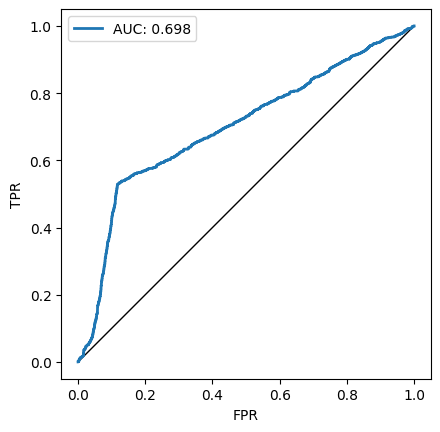

In [11]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting


input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = labels_train,
  labels_test = labels_test
)

# Run several attacks for different data slices
attacks_result = mia.run_attacks(input,
                                 SlicingSpec(
                                     entire_dataset = True,
                                     by_class = True,
                                     by_classification_correctness = True
                                 ),
                                 attack_types = [
                                     AttackType.THRESHOLD_ATTACK,
                                     AttackType.LOGISTIC_REGRESSION,
                                     AttackType.MULTI_LAYERED_PERCEPTRON,
                                        # # AttackType.RANDOM_FOREST,
                                    AttackType.K_NEAREST_NEIGHBORS,
                                     ])

# Plot the ROC curve of the best classifier
fig = plotting.plot_roc_curve(
    attacks_result.get_result_with_max_auc().roc_curve)

# Print a user-friendly summary of the attacks
print(attacks_result.summary(by_slices = True))

/home/junaid/anaconda3/envs/torch_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/junaid/anaconda3/envs/torch_env/lib/python3.10/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


32/32 [==============================] - 0s 1ms/step
Target model is #0


/home/junaid/anaconda3/envs/torch_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Advanced MIA attack with Gaussian: auc = 0.4821 adv = 0.0531


/home/junaid/anaconda3/envs/torch_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Advanced MIA attack with offset: auc = 0.4905 adv = 0.0456
Baseline MIA attack: auc = 0.5188 adv = 0.0440
Target model is #1


/home/junaid/anaconda3/envs/torch_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Advanced MIA attack with Gaussian: auc = 0.6004 adv = 0.2267


/home/junaid/anaconda3/envs/torch_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Advanced MIA attack with offset: auc = 0.3673 adv = 0.2101
Baseline MIA attack: auc = 0.4039 adv = 0.2724
Target model is #2


/home/junaid/anaconda3/envs/torch_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Advanced MIA attack with Gaussian: auc = 0.5819 adv = 0.2261


/home/junaid/anaconda3/envs/torch_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Advanced MIA attack with offset: auc = 0.3687 adv = 0.2099
Baseline MIA attack: auc = 0.3859 adv = 0.3040


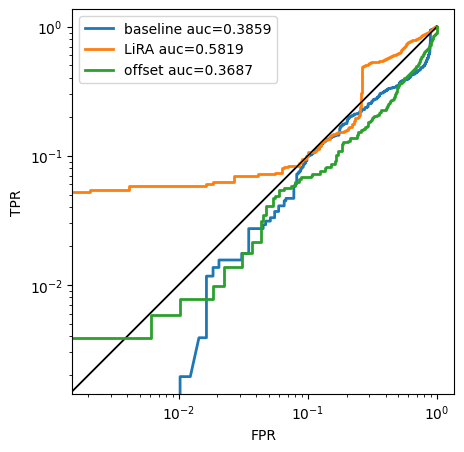

In [12]:
import numpy as np
from typing import Tuple
from scipy import special
from sklearn import metrics

import tensorflow as tf

import tensorflow_datasets as tfds

# Set verbosity.
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
import functools
import matplotlib.pyplot as plt
import tensorflow_privacy
import gc
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackResultsCollection
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyMetric
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyReportMetadata
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import privacy_report
from tensorflow_privacy.privacy.privacy_tests import utils
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import advanced_mia as amia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import plotting as mia_plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from skorch import NeuralNetClassifier




lr=1e-3
num_shadows=2

plt.set_loglevel (level = 'warning')
def plot_curve_with_area(x, y, xlabel, ylabel, ax, label, title=None):
  
  ax.plot([0, 1], [0, 1], 'k-', lw=1.0)
  ax.plot(x, y, lw=2, label=label)
  ax.set(xlabel=xlabel, ylabel=ylabel)
  ax.set(aspect=1, xscale='log', yscale='log')
  ax.title.set_text(title)
  

def get_stat_and_loss_aug(model,
                          x,
                          y,
                          torch_mod=False,
                          sample_weight= None,):

  
  if torch_mod:
    losses, stat = [], []
    # Extract the third column into a new variable
    col3 = x[:, :, :, 2]

    # Reverse the ordering of the elements along the row axis
    col3_rev = col3[::-1, :]

    # Create a new array with the reversed third column
    x_rev = np.empty_like(x)
    x_rev[:, :, :, :2] = x[:, :, :, :2] # copy the first two columns
    x_rev[:, :, :, 2] = col3_rev       # use the reversed third column
    x_rev[:, :, :, 3:] = x[:, :, :, 3:] # copy the remaining columns

    for data in [x]:
            #check if x and y are tensors, if not convert to tensors
        if not isinstance(data, torch.Tensor):
            data=torch.from_numpy(data)

        prob = amia.convert_logit_to_prob(
            model(data).detach().numpy())
        

        losses.append(utils.log_loss(y, prob, sample_weight=None))

        stat.append(
            amia.calculate_statistic(
                prob, y, sample_weight=None))
        

    return np.vstack(stat).transpose(1, 0), np.vstack(losses).transpose(1, 0)
  
  
  else:
    losses, stat = [], []
    # Extract the third column into a new variable
    col3 = x[:, :, :, 2]

    # Reverse the ordering of the elements along the row axis
    col3_rev = col3[::-1, :]

    # Create a new array with the reversed third column
    x_rev = np.empty_like(x)
    x_rev[:, :, :, :2] = x[:, :, :, :2] # copy the first two columns
    x_rev[:, :, :, 2] = col3_rev       # use the reversed third column
    x_rev[:, :, :, 3:] = x[:, :, :, 3:] # copy the remaining columns

    for data in [x]:
        
        prob = amia.convert_logit_to_prob(
                model.predict(data))
      
        losses.append(utils.log_loss(y, prob, sample_weight=sample_weight))
        stat.append(
                amia.calculate_statistic(
                    prob, y, sample_weight=sample_weight))
        return np.vstack(stat).transpose(1, 0), np.vstack(losses).transpose(1, 0)
    




in_indices = [] 
stat=[]
losses=[]

for i in range(num_shadows+1):
    # Generate a binary array indicating which example to include for training
    in_indices.append(np.random.binomial(1, 0.5, len(X)).astype(bool))

    # Train the shadow models
    if i==0:
        yp=np.argmax(y, axis=1).astype(int)
        yp=yp.reshape(-1,1)
        s,l=get_stat_and_loss_aug(target_model,X,yp,torch_mod=True)
        stat.append(s)
        losses.append(l)


    else:
        shadow_model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(1,28, 28)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
        ])

        # shadow_model=tf.keras.clone_model(model)

        shadow_model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=['accuracy'])

        shadow_model.fit(X[in_indices[-1]], y[in_indices[-1]], epochs=20, batch_size=32, verbose=0)
        yp=np.argmax(y, axis=1).astype(int)
        yp=yp.reshape(-1,1)
        s,l=get_stat_and_loss_aug(shadow_model, X,yp,torch_mod=False)
        stat.append(s)
        losses.append(l)
        
    # Avoid OOM
    tf.keras.backend.clear_session()
    gc.collect()



for idx in range(num_shadows+1):
  print(f'Target model is #{idx}')
  stat_target = stat[idx]  # statistics of target model, shape (n, k)
  in_indices_target = in_indices[idx]  # ground-truth membership, shape (n,)

  stat_shadow = np.array(stat[:idx] + stat[idx + 1:])
  in_indices_shadow = np.array(in_indices[:idx] + in_indices[idx + 1:])
  stat_in = [stat_shadow[:, j][in_indices_shadow[:, j]] for j in range(len(X))]
  stat_out = [stat_shadow[:, j][~in_indices_shadow[:, j]] for j in range(len(X))]

  # Compute the scores and use them for MIA
  scores = amia.compute_score_lira(
      stat_target, stat_in, stat_out, fix_variance=True)
  attack_input = AttackInputData(
      loss_train=scores[in_indices_target],
      loss_test=scores[~in_indices_target],
      sample_weight_train=None,
      sample_weight_test=None)
  result_lira = mia.run_attacks(attack_input).single_attack_results[0]
  print('Advanced MIA attack with Gaussian:',
        f'auc = {result_lira.get_auc():.4f}',
        f'adv = {result_lira.get_attacker_advantage():.4f}')

  scores = -amia.compute_score_offset(stat_target, stat_in, stat_out)
  attack_input = AttackInputData(
      loss_train=scores[in_indices_target],
      loss_test=scores[~in_indices_target],
      sample_weight_train=None,
      sample_weight_test=None)
  result_offset = mia.run_attacks(attack_input).single_attack_results[0]
  print('Advanced MIA attack with offset:',
        f'auc = {result_offset.get_auc():.4f}',
        f'adv = {result_offset.get_attacker_advantage():.4f}')

  # Compare with the baseline MIA using the loss of the target model
  loss_target = losses[idx][:, 0]
  attack_input = AttackInputData(
      loss_train=loss_target[in_indices_target],
      loss_test=loss_target[~in_indices_target],
      sample_weight_train=None,
      sample_weight_test=None)
  result_baseline = mia.run_attacks(attack_input).single_attack_results[0]
  print('Baseline MIA attack:', f'auc = {result_baseline.get_auc():.4f}',
        f'adv = {result_baseline.get_attacker_advantage():.4f}')

# Plot and save the AUC curves for the three methods.
_, ax = plt.subplots(1, 1, figsize=(5, 5))
for res, title in zip([result_baseline, result_lira, result_offset],
                      ['baseline', 'LiRA', 'offset']):
  label = f'{title} auc={res.get_auc():.4f}'
  mia_plotting.plot_roc_curve(
      res.roc_curve,
      functools.partial(plot_curve_with_area, ax=ax, label=label))
plt.legend()